In [1]:
%cd ..

/Users/mariusarlauskas/Desktop/Github/Map-Sim


In [2]:
import matplotlib.pyplot as plt
from skimage.filters import median
from skimage.transform import resize

from scipy.stats import norm
from scipy.special import expit

import random as rng
import numpy as np

import imageio
import numpy as np
from PIL import Image

In [3]:
PIXEL_DENSITY_THRESHOLD = 0.72
RESIZE_FACTOR = 0.15

MAX_VAR_TRANSMISSION_RATE = 0.15
BASE_TRANSMISSION_RATE = 0.05
KM_RADIUS = 10
INFECTION_RADIUS = int(KM_RADIUS * 5 * RESIZE_FACTOR) # Roughly 10 km 5 pixels = 1 km
MAX_NEARBY_PEOPLE = INFECTION_RADIUS ** 2

MEAN_DAYS_TO_RECOVERY = 14
RECOVERY_STD_DEVIATION = 3

# Because this is an image, coordinates are (y, x)
INITIAL_INFECTED_COOR = [
    (800, 1000),
    (900, 1375),
]

# Resize Initial_Infected_Coor
INITIAL_INFECTED_COOR = [(int(x*RESIZE_FACTOR), int(y*RESIZE_FACTOR)) for x, y in INITIAL_INFECTED_COOR]


def get_well_probability(day):
    if day > 31:
        return 1
    return norm.pdf(day, MEAN_DAYS_TO_RECOVERY, RECOVERY_STD_DEVIATION)

def get_infected_probability(n_infected_neighbors):
    if n_infected_neighbors == 0:
        return 0
    x = n_infected_neighbors / MAX_NEARBY_PEOPLE * 10 - 5
    return expit(x) * MAX_VAR_TRANSMISSION_RATE + BASE_TRANSMISSION_RATE


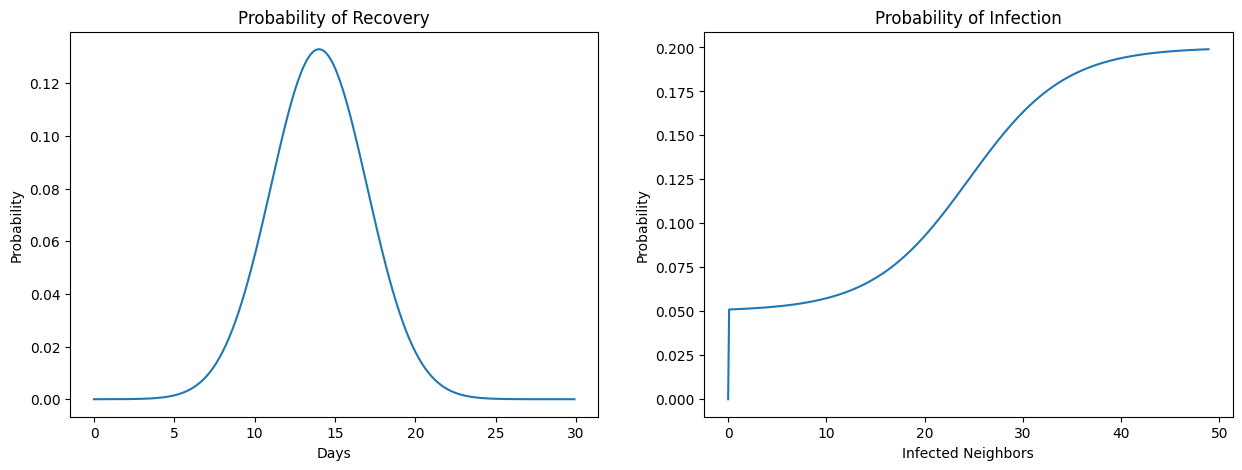

In [4]:
x = np.arange(0, 30, 0.1)
y = [get_well_probability(i) for i in x]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(x, y)
ax[0].set_title("Probability of Recovery")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Probability")

x = np.arange(0, MAX_NEARBY_PEOPLE, 0.1)
y = [get_infected_probability(i) for i in x]

ax[1].plot(x, y)
ax[1].set_title("Probability of Infection")
ax[1].set_xlabel("Infected Neighbors")
ax[1].set_ylabel("Probability")
plt.show()

In [5]:
image = plt.imread('input/pop_density.png')
print(type(image))

<class 'numpy.ndarray'>


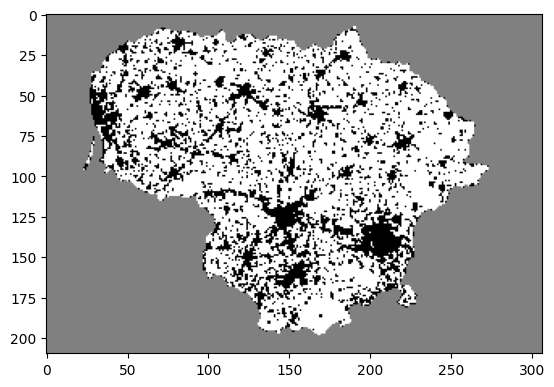

In [6]:

image = plt.imread('input/pop_density.png')
filter_image = image[:,:,3]

image_height, image_width = image.shape[:2]

image = image[:,:,1]
image = median(image)

image = resize(image, (image_height*RESIZE_FACTOR, image_width*RESIZE_FACTOR), anti_aliasing=True)
filter_image = resize(filter_image, (image_height*RESIZE_FACTOR, image_width*RESIZE_FACTOR), anti_aliasing=True)

image[image > PIXEL_DENSITY_THRESHOLD] = 1
image[image <= PIXEL_DENSITY_THRESHOLD] = 0
image[filter_image < 0.5] = 0.5


plt.imshow(image, cmap='gray')
plt.show()

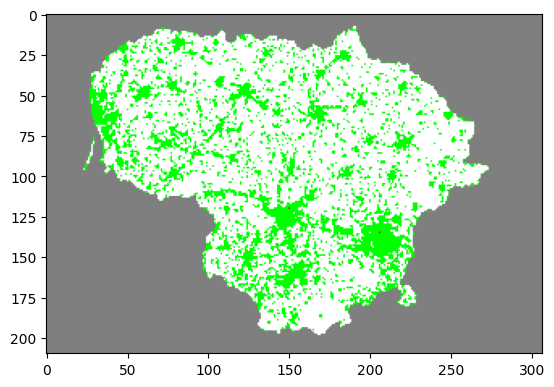

In [7]:
class IzolationZone:
    def __init__(self, name, x_min, x_max, y_min, y_max):
        self.name = name

        self.x_min = x_min
        self.x_max = x_max

        self.y_min = y_min
        self.y_max = y_max
    
    def is_in_zone(self, x, y):
        """ Returns True if the given point is in the zone """
        return self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max

class Person:
    def __init__(self, x, y, status):
        self.x = x
        self.y = y
        self.status = status
        self.izolation_zone = None

        self.days_infected = 0

        self.next_status = None

    def __str__(self):
        return f'Person({self.x}, {self.y}, {self.status})'
    
    def _count_infected_neighbours(self, people):
        """ Searches for infected neighbours within a radius of INFECTION_RADIUS """
        infected_neighbours = sum(
            1 for person in people if person.status == 'infected' and
            (person.x - self.x)**2 + (person.y - self.y)**2 <= INFECTION_RADIUS**2 and
            person.izolation_zone == self.izolation_zone
        )
        return infected_neighbours
    
    def calculate(self, people):
        """ Updates the status of the person based on the status of their neighbours """
        if self.status == 'infected':
            self.days_infected += 1
            if rng.random() < get_well_probability(self.days_infected):
                self.next_status = 'recovered'
        elif self.status == 'susceptible':
            if rng.random() < get_infected_probability(self._count_infected_neighbours(people)):
                self.next_status = 'infected'
            else:
                self.next_status = self.status
        elif self.status == 'recovered':
            self.next_status = self.status

    def update(self):
        """ Updates the status of the person """
        self.status = self.next_status

    def set_izolation_zone(self, zones):
        """ Sets the izolation zone of the person based on their coordinates """
        for zone in zones:
            if zone.is_in_zone(self.x, self.y):
                self.izolation_zone = zone.name
                break
    
class Population:
    def __init__(self, people, izolation_zones):
        self.people = people
        self.izolation_zones = izolation_zones

    def calculate(self):
        """ Calculates the next status of all people """
        for person in self.people:
            person.calculate(self.people)

    def update(self):
        """ Updates the status of all people """
        for person in self.people:
            person.update()
        
    def set_izolation_zones(self):
        """ Sets the izolation zones of all people """
        for person in self.people:
            person.set_izolation_zone(self.izolation_zones)
    
        


def generate_population(image, izolation_zones):
    """ Generates a population of people based on the given image """
    people = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 0:
                people.append(Person(i, j, 'susceptible'))
    population = Population(people, izolation_zones)
    population.set_izolation_zones()

    for x, y in INITIAL_INFECTED_COOR:
        for person in population.people:
            if person.x == x and person.y == y:
                person.status = 'infected'
                break

    return population

# TODO: Assign people to population centers based
# TODO: based on their proximity to the population centers
POPULATION_CENTERS_COOR = [
    (850, 975), # Kaunas
    (925, 1350), # Vilnius
    (270, 975), # Siauliai/Panevezys
    (270, 300), # Klaipeda
    (1100, 975), # Alytus
    (435, 1450), # Vilnius
    ]

POPULATION_CENTERS_COOR = [(int(x*RESIZE_FACTOR), int(y*RESIZE_FACTOR)) for x, y in POPULATION_CENTERS_COOR]
    

def generate_image(population, boundary_image, izolation_zones):
    """ Generates an image based on the given population """
    # If person is healthy, set pixel to green
    # If person is infected, set pixel to red
    # If person is recovered, set pixel to yellow

    image = np.ones((boundary_image.shape[0], boundary_image.shape[1], 3))

    for person in population.people:
        if person.status == 'susceptible':
            image[person.x, person.y] = [0, 1, 0]
        elif person.status == 'infected':
            image[person.x, person.y] = [1, 0, 0]
        elif person.status == 'recovered':
            image[person.x, person.y] = [1, 1, 0]

    # set pixels outside yellow region to grey
    image[boundary_image < 0.5] = [0.5, 0.5, 0.5]

    # set populations centers to black
    #for x, y in POPULATION_CENTERS_COOR:
    #    image[x, y] = [0, 0, 0]
    

    return image


TOTAL_ZONE = IzolationZone('total', 0, 1400*RESIZE_FACTOR, 0, 2000*RESIZE_FACTOR)

population = generate_population(image, [TOTAL_ZONE])
new_image = generate_image(population, filter_image, [TOTAL_ZONE])

plt.imshow(new_image)

In [8]:

images = []

for i in range(90):
    print(f'\rDay: {i}', end='', flush=True)    
    population.calculate()
    population.update()
    new_image = generate_image(population, filter_image, [TOTAL_ZONE])

    pil_image = Image.fromarray((new_image * 255).astype(np.uint8))
    images.append(pil_image)

output_path = 'output/output.gif'
imageio.mimsave(output_path, images, duration=10)  # Adjust the duration as needed

Day: 89